In [1]:
from keras.datasets import mnist
from keras.layers import Input,Conv2D,Activation,Dense,Lambda,Flatten,Embedding,PReLU,BatchNormalization
from keras.models import Model
import keras.backend as K
from keras.utils import to_categorical
import numpy as np
from keras.callbacks import EarlyStopping

In [2]:
from keras.datasets import mnist
# load data

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
inputs=Input((28,28,1))
x=Conv2D(32,(3,3))(inputs)
x=BatchNormalization()(x)
x=PReLU()(x)
x=Conv2D(32,(3,3))(x)
x=BatchNormalization()(x)
x=PReLU()(x)
x=Conv2D(64,(5,5))(x)
x=BatchNormalization()(x)
x=PReLU()(x)
x=Conv2D(64,(5,5))(x)
x=BatchNormalization()(x)
x=PReLU()(x)
x=Conv2D(128,(7,7))(x)
x=BatchNormalization()(x)
x=PReLU()(x)
x=Conv2D(128,(7,7))(x)
x=BatchNormalization()(x)
x=PReLU()(x)
x=Flatten()(x)
x=Dense(2)(x)
out1=PReLU(name="out1")(x)
out2=Dense(10,activation="softmax")(out1)

model=Model(inputs,out2)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
p_re_lu (PReLU)              (None, 26, 26, 32)        21632     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 24, 24, 32)       

In [4]:
lambda_c=1
input_=Input(shape=(1,))
centers=Embedding(10,2)(input_)
intra_loss=Lambda(lambda x:K.sum(K.square(x[0]-x[1][:,0]),1,keepdims=True))([out1,centers])
model_center_loss=Model([inputs,input_],[out2,intra_loss])
model_center_loss.compile(optimizer="sgd",
                          loss=["categorical_crossentropy",lambda y_true,y_pred:y_pred],
                          loss_weights=[1,lambda_c/2.],
                          metrics=["acc"])
model_center_loss.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 26, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 26, 26, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 26, 26, 32)   21632       batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
x_train=x_train.astype("float32")
x_test=x_test.astype("float32")
x_train/=255.
x_test/=255.
x_train=np.expand_dims(x_train,axis=-1)
x_test=np.expand_dims(x_test,axis=-1)

y_train_one_hot=to_categorical(y_train)
y_test_one_hot=to_categorical(y_test)

print(x_train.shape)
print(y_train.shape)
print(y_train_one_hot.shape)

(60000, 28, 28, 1)
(60000,)
(60000, 10)


In [6]:
dummy_matrix1=np.zeros((x_train.shape[0],1))
dummy_matrix2=np.zeros((x_test.shape[0],1))

model_center_loss.fit(x=[x_train,y_train],y=[y_train_one_hot,dummy_matrix1],
                     batch_size=512,epochs=100,verbose=1,validation_data=([x_test,y_test],[y_test_one_hot,dummy_matrix2]),
                     callbacks=[EarlyStopping(monitor="val_loss",patience=20)])

Epoch 1/100
118/118 [==============================] - 13s 113ms/step - loss: 2.2934 - dense_1_loss: 2.2674 - lambda_loss: 0.0521 - dense_1_acc: 0.1485 - lambda_acc: 0.9737 - val_loss: 2.3036 - val_dense_1_loss: 2.3022 - val_lambda_loss: 0.0028 - val_dense_1_acc: 0.1135 - val_lambda_acc: 1.0000
Epoch 2/100
118/118 [==============================] - 13s 113ms/step - loss: 2.2415 - dense_1_loss: 2.1690 - lambda_loss: 0.1451 - dense_1_acc: 0.3169 - lambda_acc: 0.9280 - val_loss: 2.3042 - val_dense_1_loss: 2.3018 - val_lambda_loss: 0.0048 - val_dense_1_acc: 0.1135 - val_lambda_acc: 1.0000
Epoch 3/100
118/118 [==============================] - 14s 119ms/step - loss: 2.1972 - dense_1_loss: 2.1035 - lambda_loss: 0.1875 - dense_1_acc: 0.3701 - lambda_acc: 0.9043 - val_loss: 2.3682 - val_dense_1_loss: 2.3055 - val_lambda_loss: 0.1255 - val_dense_1_acc: 0.0958 - val_lambda_acc: 1.0000
Epoch 4/100
118/118 [==============================] - 14s 116ms/step - loss: 2.1522 - dense_1_loss: 2.0463 - la

In [7]:
func=K.function([model.input],[model.get_layer('out1').output])
test_features= func([x_test])[0]
print(test_features.shape)

test_centers=np.dot(np.transpose(y_test_one_hot),test_features)
test_centers_count=np.sum(np.transpose(y_test_one_hot),axis=1,keepdims=True)
test_centers/=test_centers_count
print(test_centers.shape)

(10000, 2)
(10, 2)


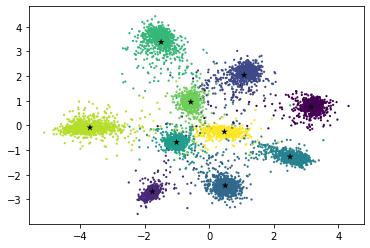

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(test_features[:,0],test_features[:,1],c=y_test,edgecolor="none",s=5)
plt.scatter(test_centers[:,0],test_centers[:,1],c="black",marker="*",edgecolor="none",s=50)
plt.show()